<a href="https://colab.research.google.com/github/ubermenchh/fun/blob/main/modern_compvis_pytorch_book/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 18157485.28it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266950.63it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5011785.30it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11773324.42it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
train_images = train_dataset.data
train_labels = train_dataset.targets

In [5]:
val_images = valid_dataset.data
val_labels = valid_dataset.targets

In [6]:
train_images.shape, train_labels.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [7]:
val_images.shape, val_labels.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [8]:
class_names = train_dataset.classes

Text(0.5, 1.0, 'Trouser')

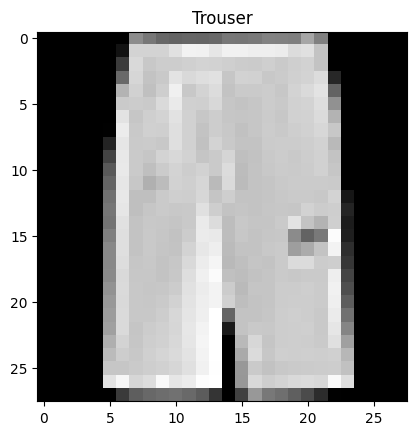

In [9]:
ix = np.random.randint(len(train_images))
plt.imshow(train_images[ix], cmap='gray')
plt.title(class_names[train_labels[ix]])

In [10]:
X_train = torch.tensor([[[[1,2,3,4],[2,3,4,5],
 [5,6,7,8],[1,3,4,5]]],
  [[[-1,2,3,-4],[2,-3,4,5],
   [-5,6,-7,8],[-1,-3,-4,-5]]]]).to(device).float()
X_train /= 8
y_train = torch.tensor([0, 1]).to(device).float()

In [11]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1, 1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [12]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, X_train);

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [13]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    pred = model(x)
    batch_loss = loss_fn(pred.squeeze(0), y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [14]:
trn_dl = DataLoader(TensorDataset(X_train, y_train))

In [15]:
for epoch in range(2000):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

In [16]:
model(X_train[:1])

tensor([[0.5168]], device='cuda:0', grad_fn=<SigmoidBackward0>)

## Forward Propagating the output in Python

In [17]:
# Extract the layer of the model
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

In [18]:
# Extract the weight and bias of conv and linear layers
(cnn_w, cnn_b), (lin_w, lin_b) = [(layer.weight.data, layer.bias.data)
                                for layer in list(model.children()) if hasattr(layer, 'weight')]

In [19]:
# initializing a matrix of zeros to perform conv operation over the input value
h_im, w_im = X_train.shape[2:]
h_conv, w_conv = cnn_w.shape[2:]
sumprod = torch.zeros((h_im - h_conv + 1, w_im - w_conv + 1))

In [20]:
# convoluting across the first input
for i in range(h_im - h_conv + 1):
    for j in range(w_im - w_conv + 1):
        img_subset = X_train[0, 0, i:(i+3), j:(j+3)]
        model_filter = cnn_w.reshape(3, 3)
        val = torch.sum(img_subset * model_filter) + cnn_b
        sumprod[i, j] = val

In [21]:
sumprod

tensor([[-0.7712, -0.8330],
        [-0.4873, -0.5721]])

In [22]:
sumprod.clamp_min_(0) # ReLU

tensor([[0., 0.],
        [0., 0.]])

In [23]:
pooling_layer_output = torch.max(sumprod) # MaxPooling
pooling_layer_output

tensor(0.)

In [24]:
intermediate_output_value = pooling_layer_output * lin_w + lin_b # Linear layer
intermediate_output_value

tensor([[0.0674]], device='cuda:0')

In [25]:
import torch.nn.functional as F

print(F.sigmoid(intermediate_output_value)) # sigmoid

tensor([[0.5168]], device='cuda:0')


In [26]:
print(F.sigmoid(intermediate_output_value)), model(X_train[:1])

tensor([[0.5168]], device='cuda:0')


(None, tensor([[0.5168]], device='cuda:0', grad_fn=<SigmoidBackward0>))

## Classifying images using Deep CNNs

In [27]:
class FashionMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 1, 28, 28)
        self.x, self.y = x, y

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

In [28]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [29]:
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [30]:
def train_batch(x, y, model, opt, loss_fn):
    pred = model(x)
    batch_loss = loss_fn(pred, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [31]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    pred = model(x)
    max_values, argmaxes = pred.max(-1)
    is_corr = argmaxes == y
    return is_corr.cpu().numpy().tolist()

In [32]:
def get_data():
    train_data = FashionMNISTDataset(train_images, train_labels)
    train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
    val_data = FashionMNISTDataset(val_images, val_labels)
    val_dl = DataLoader(val_data, batch_size=32, shuffle=True)
    return train_dl, val_dl

In [33]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    pred = model(x)
    val_loss = loss_fn(pred, y)
    return val_loss.item()

In [34]:
train_dl, val_dl = get_data()

In [35]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(5):
    train_epoch_losses, train_epoch_accs = [], []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_corr = accuracy(x, y, model)
        train_epoch_accs.extend(is_corr)
    train_epoch_acc = np.array(train_epoch_accs).mean()

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_corr = accuracy(x, y, model)
        valid_loss = val_loss(x, y, model)
    val_epoch_acc = np.mean(val_is_corr)

    print(f"Epoch {epoch}: Train Loss - {train_epoch_loss:.2f} | Train Accuracy - {train_epoch_acc:.2f} | Valid Loss - {valid_loss:.2f} | Valid Accuracy - {val_epoch_acc:.2f}")

    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)
    val_losses.append(valid_loss)
    val_accs.append(val_epoch_acc)

Epoch 0: Train Loss - 0.43 | Train Accuracy - 0.89 | Valid Loss - 0.36 | Valid Accuracy - 0.81
Epoch 1: Train Loss - 0.28 | Train Accuracy - 0.91 | Valid Loss - 0.10 | Valid Accuracy - 1.00
Epoch 2: Train Loss - 0.23 | Train Accuracy - 0.93 | Valid Loss - 0.14 | Valid Accuracy - 0.88
Epoch 3: Train Loss - 0.19 | Train Accuracy - 0.94 | Valid Loss - 0.06 | Valid Accuracy - 1.00
Epoch 4: Train Loss - 0.16 | Train Accuracy - 0.96 | Valid Loss - 0.34 | Valid Accuracy - 0.88


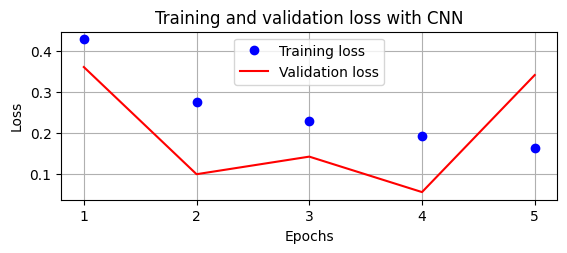

<ipython-input-36-012d2e90783d>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


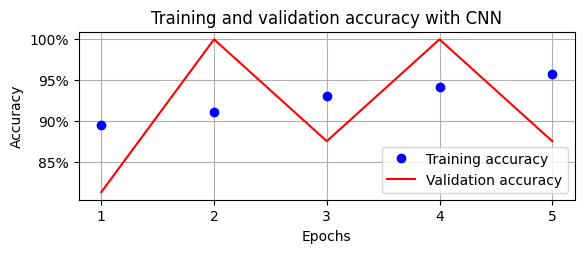

In [36]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs, val_accs, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

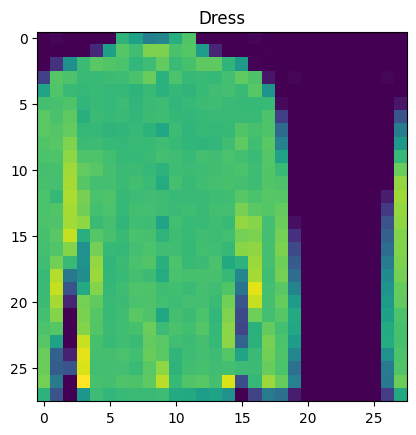

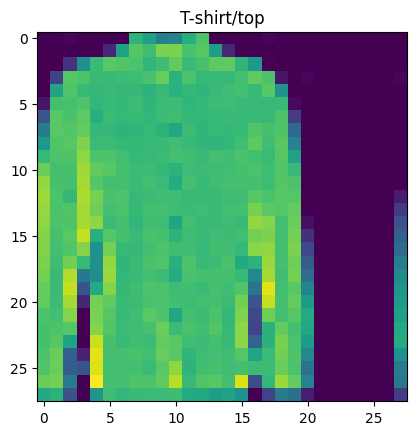

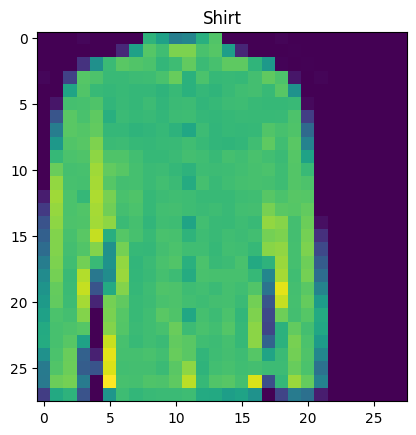

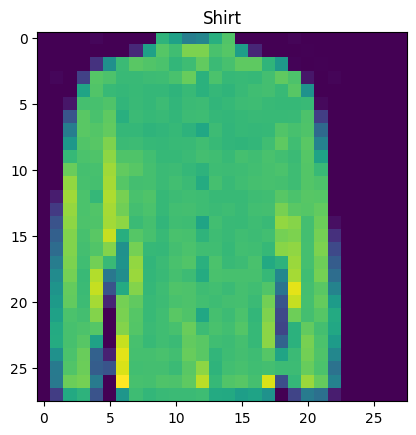

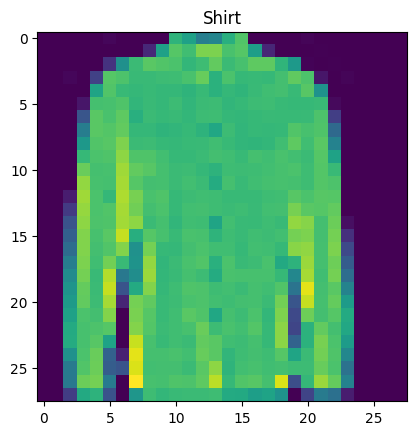

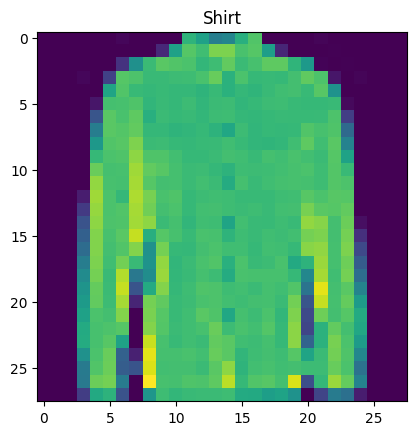

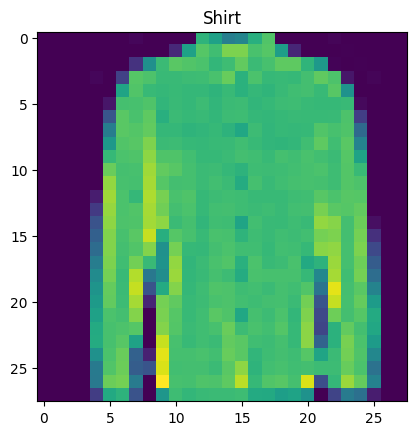

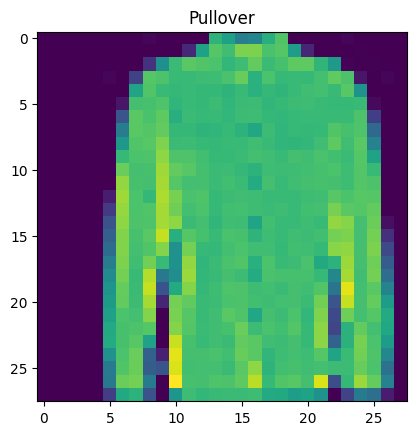

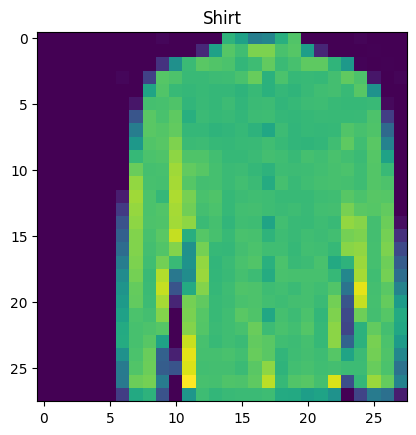

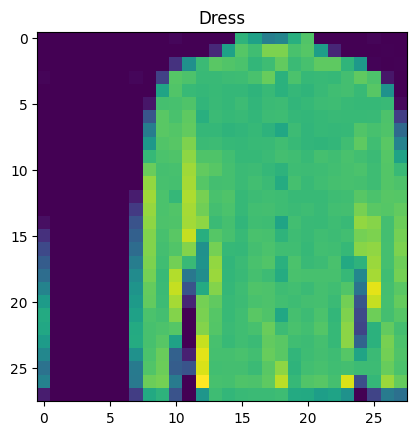

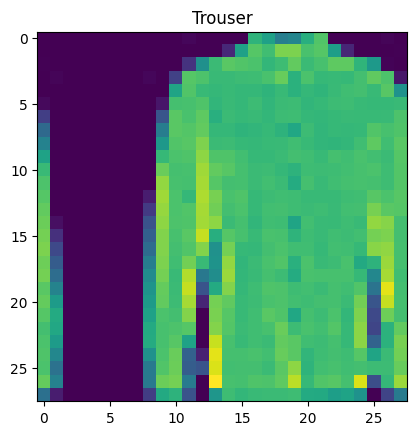

In [37]:
preds = []
ix = 42069
for px in range(-5,6):
  img = train_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(class_names[pred[0].argmax()])
  plt.show()

<Axes: title={'center': 'Probability of each class for various translations'}>

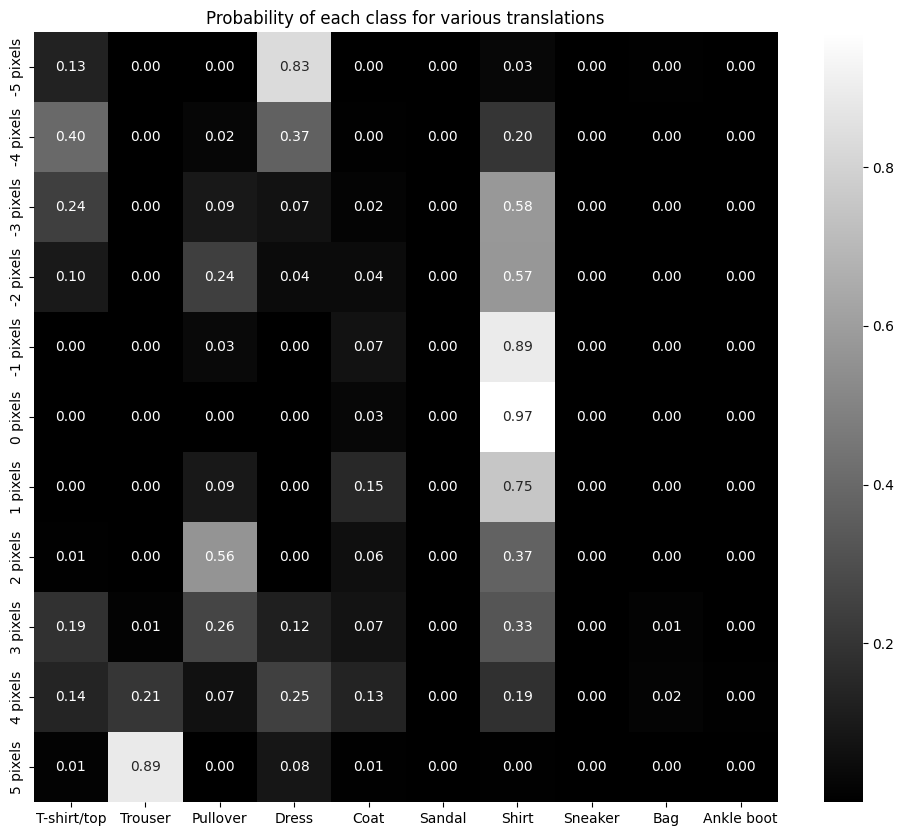

In [38]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11, 10), annot=True, ax=ax, fmt='.2f',
            xticklabels=class_names, yticklabels=[str(i) + str(' pixels') for i in range(-5, 6)],
            cmap='gray')

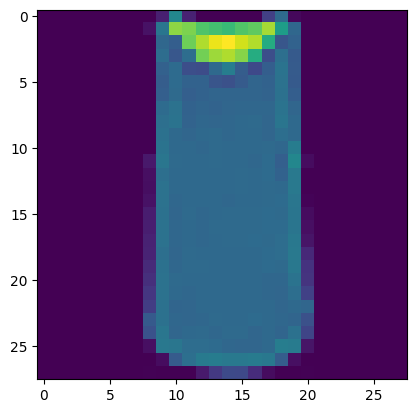

In [39]:
im, c = train_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

In [40]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

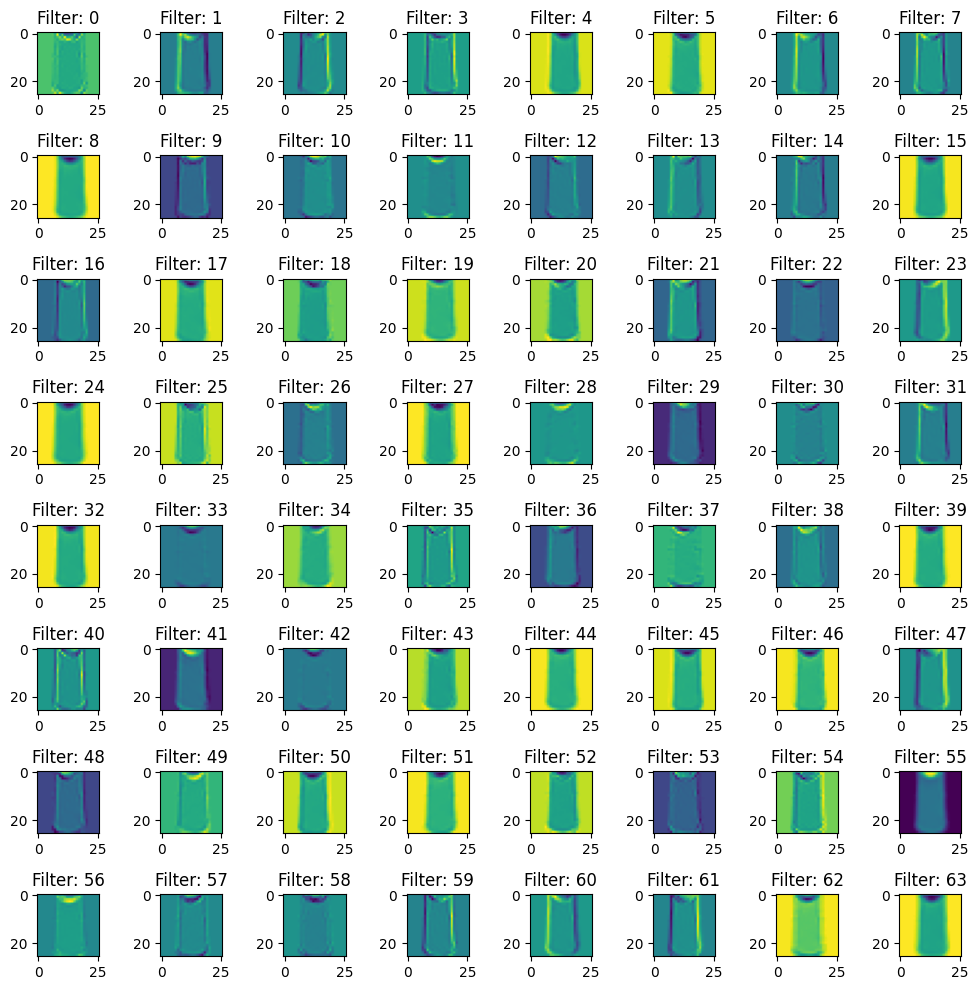

In [41]:
fig, ax = plt.subplots(8, 8, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: ' + str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

In [43]:
class_names[0]

'T-shirt/top'

In [44]:
x, y = next(iter(train_dl))
x2 = x[y==0]
x2 = x2.view(-1, 1, 28, 28)

In [58]:
x2.shape

torch.Size([3, 1, 28, 28])

In [45]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

In [48]:
first_layer_output.shape

torch.Size([3, 64, 26, 26])

In [55]:
for ix, axis in enumerate(ax.flat):
    print(ix)

0
1
2
3


IndexError: ignored

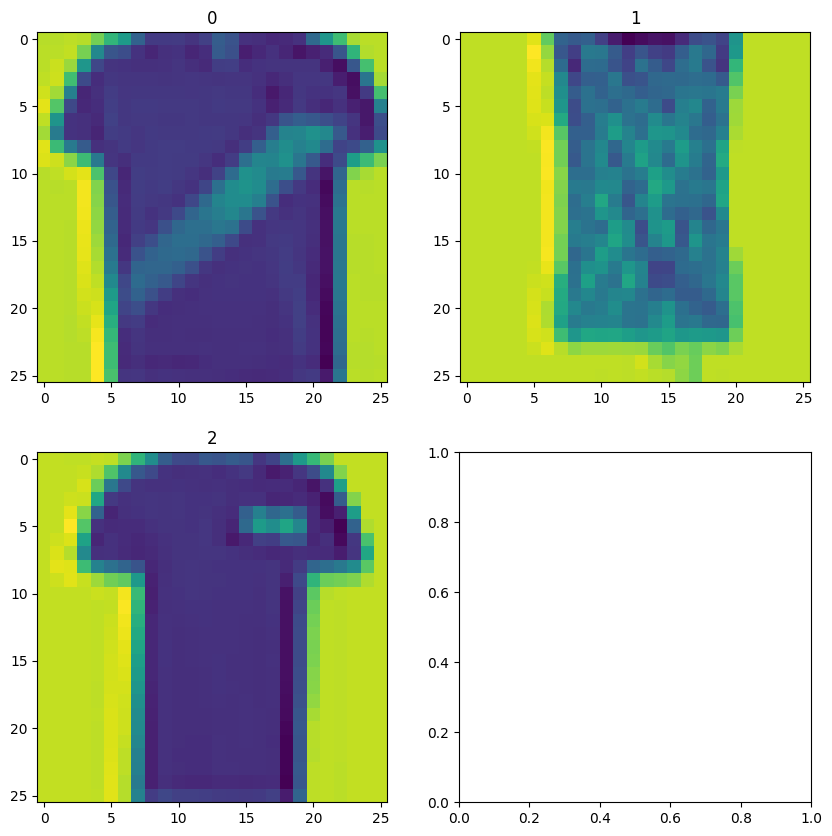

In [60]:
n = 2
fig, ax = plt.subplots(n, n, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(first_layer_output[ix, 4, :, :].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [61]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

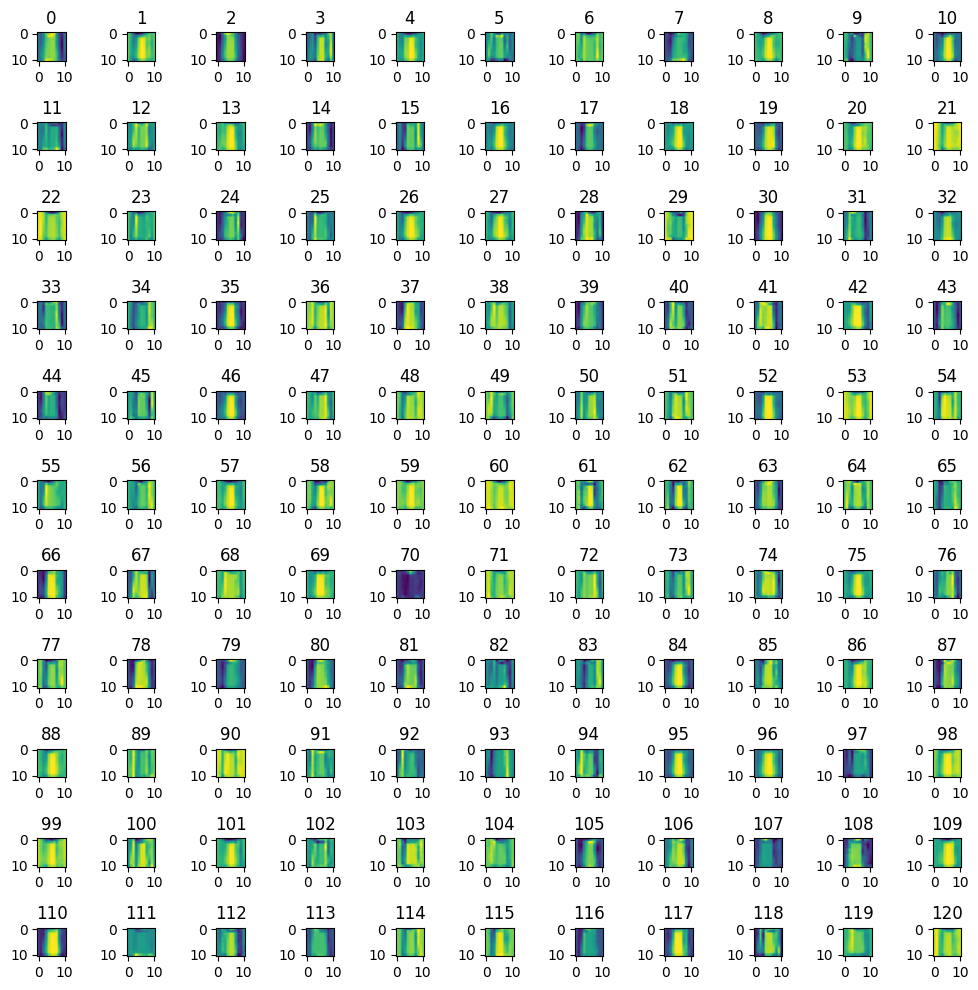

In [63]:
fig, ax = plt.subplots(11, 11, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

IndexError: ignored

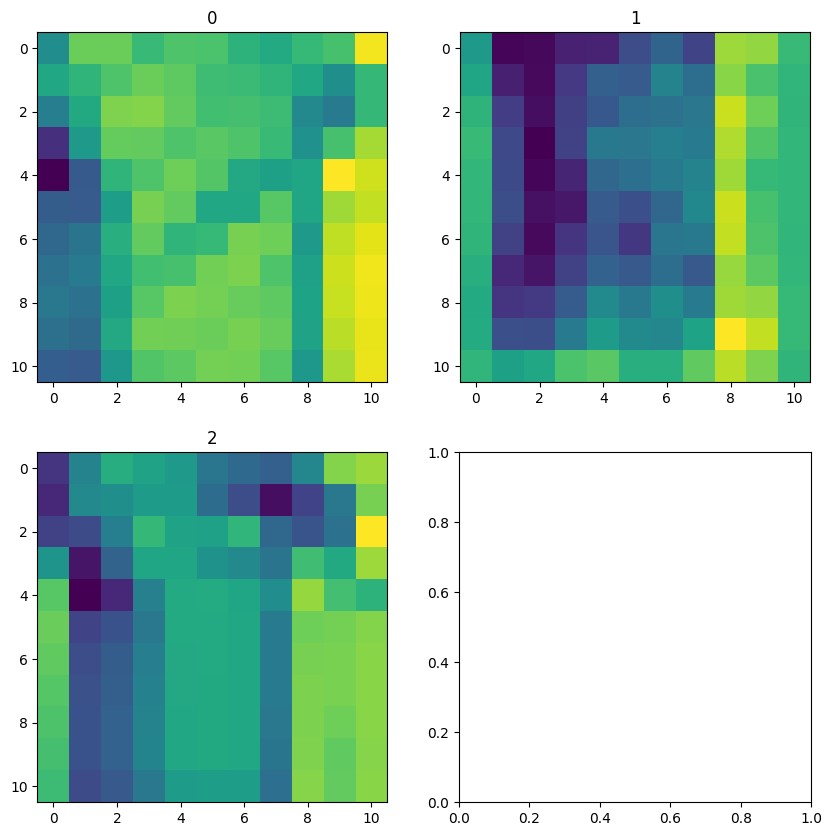

In [65]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(x2).detach()
fig, ax = plt.subplots(2, 2, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
 axis.imshow(second_intermediate_output[ix,34,:,:].cpu())
 axis.set_title(str(ix))
plt.tight_layout()
plt.show()


In [68]:
custom_dl = DataLoader(train_dataset, batch_size=2048, drop_last=True)

In [72]:
x, y = next(iter(custom_dl))
x2 = x[y==0].to(device)
x2 = x2.view(len(x2), 1, 28, 28)

In [73]:
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

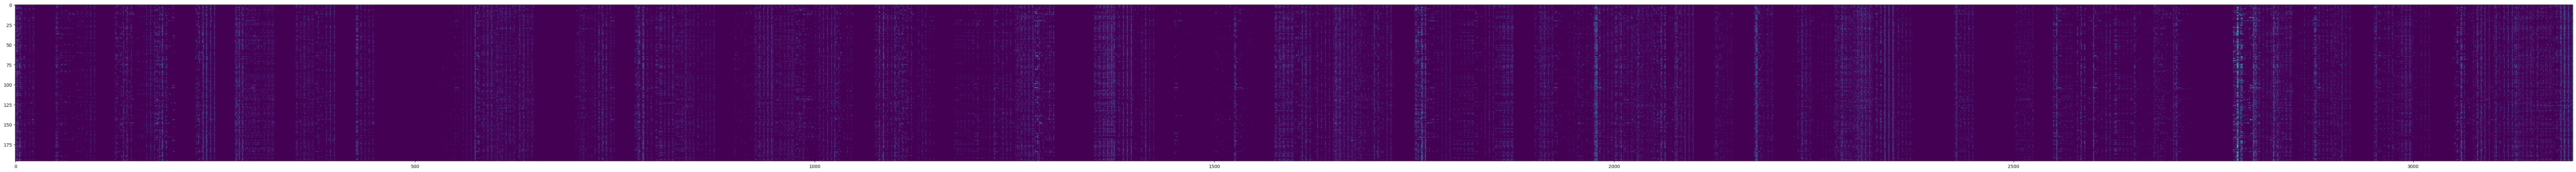

In [74]:
plt.figure(figsize=(100, 10))
plt.imshow(flatten_layer_output.cpu())